In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# Sample data (replace this with your actual dataset)
data = pd.DataFrame(
    {
        "individual_id": [1, 1, 2, 3, 3],
        "drug_name": ["Drug A", "Drug B", "Drug C", "Drug D", "Drug E"],
        "duration": [30, 10, 15, 20, 10],
        "atc_code": [
            ["A01AA01", "A01AB02"],
            ["A01AA01"],
            ["B02BB01"],
            ["A01BB01", "B02BB02", "C03CA01"],
            ["A01BB01"],
        ],
    }
)
data

,individual_id,drug_name,duration,atc_code
0,1,Drug A,30,"[A01AA01, A01AB02]"
1,1,Drug B,10,[A01AA01]
2,2,Drug C,15,[B02BB01]
3,3,Drug D,20,"[A01BB01, B02BB02, C03CA01]"
4,3,Drug E,10,[A01BB01]


In [4]:
# Step 1: Extract 3rd-level ATC codes and split duration equally for multiple ATC codes
def process_row(row):
    atc_codes = [
        code[:3] for code in row["atc_code"]
    ]  # Take only the first 3 characters
    equal_duration = row["duration"] / len(atc_codes)
    return pd.DataFrame(
        {
            "individual_id": row["individual_id"],
            "atc_code": atc_codes,
            "duration": equal_duration,
        }
    )


processed_data = pd.concat([process_row(row) for _, row in data.iterrows()])
processed_data

,individual_id,atc_code,duration
0,1,A01,15.000000
1,1,A01,15.000000
0,1,A01,10.000000
0,2,B02,15.000000
0,3,A01,6.666667
1,3,B02,6.666667
2,3,C03,6.666667
0,3,A01,10.000000


In [6]:
# Step 2: Pivot the data to create the feature matrix
feature_matrix = processed_data.pivot_table(
    index="individual_id", columns="atc_code", values="duration", aggfunc="sum"
).fillna(0)
feature_matrix

atc_code,A01,B02,C03
individual_id,,,
1,40.000000,0.000000,0.000000
2,0.000000,15.000000,0.000000
3,16.666667,6.666667,6.666667


In [7]:
# Step 3: Scale the data (standardizing is usually a good idea before clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)
scaled_features

array([[ 1.28684238, -1.1769647 , -0.70710678],
       [-1.15138528,  1.26750044, -0.70710678],
       [-0.13545709, -0.09053575,  1.41421356]])

In [8]:
# Step 4: (Optional) Dimensionality Reduction using PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for easy visualization
reduced_features = pca.fit_transform(scaled_features)
reduced_features

array([[ 1.75799959, -0.67130221],
       [-1.69367279, -0.7508115 ],
       [-0.06432679,  1.42211371]])

In [9]:
# Step 5: Apply KMeans Clustering
kmeans = KMeans(n_clusters=3)  # Choose the number of clusters
clusters = kmeans.fit_predict(reduced_features)

# Add cluster labels to the original feature matrix
feature_matrix["cluster"] = clusters
feature_matrix

atc_code,A01,B02,C03,cluster
individual_id,,,,
1,40.000000,0.000000,0.000000,1
2,0.000000,15.000000,0.000000,0
3,16.666667,6.666667,6.666667,2


atc_code             A01        B02       C03  cluster
individual_id                                         
1              40.000000   0.000000  0.000000        1
2               0.000000  15.000000  0.000000        2
3              16.666667   6.666667  6.666667        0


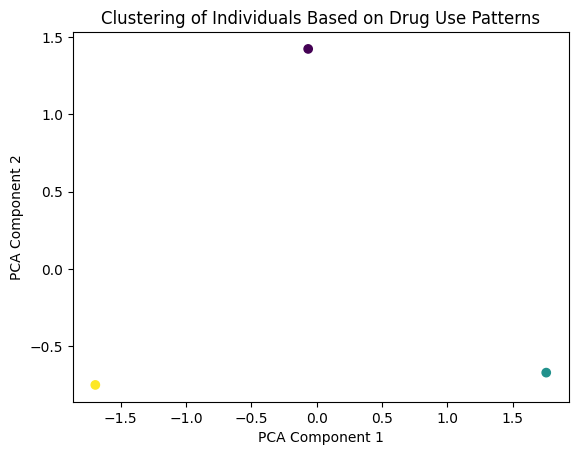

In [12]:
# Step 6: View Results
print(feature_matrix)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering of Individuals Based on Drug Use Patterns")
plt.show()